# Modelo: Random Forest Regressor
Elegí el modelo porque no asume relaciones lineales, puede capturar relaciones complejas y es robusto a outliers

---

Comenzamos cargando las librerías y preparando los datos.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/2_processed/database_rg_clean.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])

df['Año'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month

Seleccionamos las características y variable objetivo.

In [12]:
features = ['Año', 'Mes', 'HechosSimples', 'HechosMortales', 
           'HechosConLesiones', 'Lesionados', 'HechosRurales']
target = 'Total'

X = df[features]
y = df[target]

Dividimos los datos, entrenamos el modelo base y hacemos las predicciones correspondientes.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

Evaluamos el modelo.

In [14]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Métricas de evaluación del modelo base:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

Métricas de evaluación del modelo base:
RMSE: 9.18
MAE: 6.75
R2 Score: 0.99


El R2 Score de 0.99 es extremadamente alto, sugiriendo que el modelo está "memorizando" los datos en lugar de aprender patrones generalizables.

---

Visualizamos la importancia de las características.

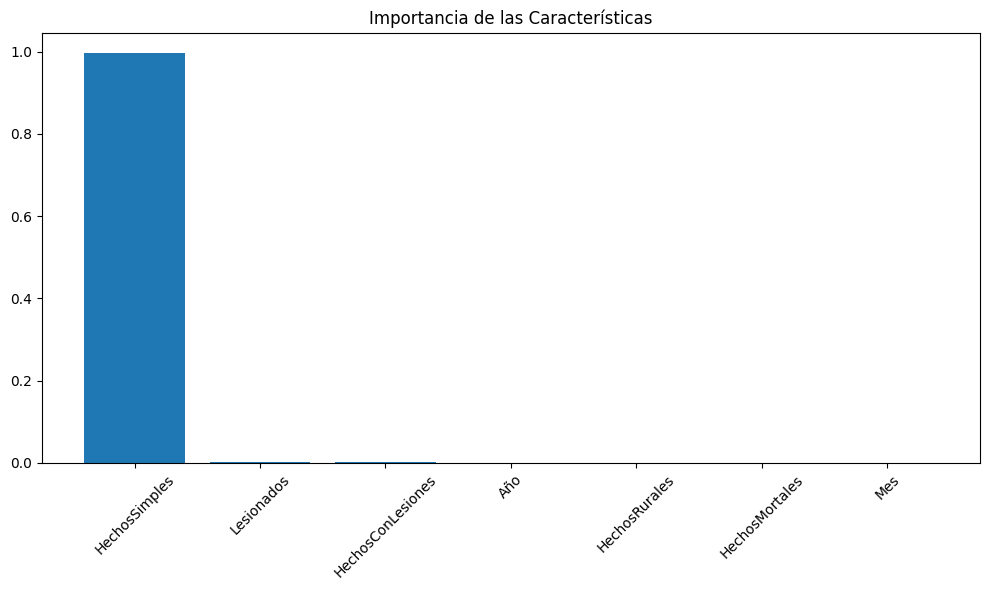

In [15]:
importancia = pd.DataFrame({
    'caracteristica': features,
    'importancia': rf_model.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importancia['caracteristica'], importancia['importancia'])
plt.title('Importancia de las Características')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Modelo: Random Forest Regressor (Sin HechosSimples)
Para mejorar el modelo, eliminaré HechosSimples del conjunto de características, ya que probablemente es una variable que "filtra" la información del total (target leakage) y reentrenare el modelo con las características restantes.

Métricas de evaluación del modelo mejorado:
RMSE: 45.31
MAE: 35.23
R2 Score: 0.87


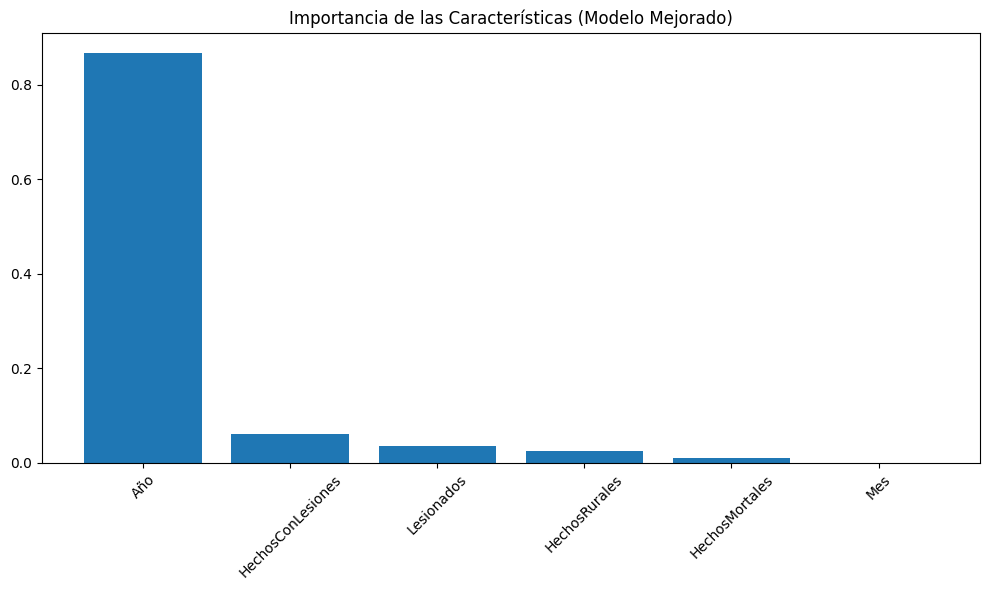

In [16]:
# 1. Redefinir las características excluyendo HechosSimples
features_mejorado = ['Año', 'Mes', 'HechosMortales', 
                    'HechosConLesiones', 'Lesionados', 'HechosRurales']

X = df[features_mejorado]
y = df[target]

# 2. Dividir los datos nuevamente
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Crear y entrenar el modelo mejorado
rf_model_mejorado = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_mejorado.fit(X_train, y_train)

# 4. Hacer predicciones
y_pred = rf_model_mejorado.predict(X_test)

# 5. Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Métricas de evaluación del modelo mejorado:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

# 6. Visualizar la nueva importancia de características
importancia = pd.DataFrame({
    'caracteristica': features_mejorado,
    'importancia': rf_model_mejorado.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importancia['caracteristica'], importancia['importancia'])
plt.title('Importancia de las Características (Modelo Mejorado)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ahora el modelo es mas realista y equilibrado, el R² Score bajó de 0,99 a 0,87, lo que es mas razonanle y sugiere menos sobreajuste. El RMSE y MAE aumentaron, lo que es esperado al eliminar el target leakage.

En cuanto a la importancia de las características, el *"Año"* es ahora la variable mas importante por mucho, mientras que HechosConLesiones y Lesionados tienen una importancia moderada.

---

Debido a que antes observamos que un fuerte incremento de casos, o mas bien, los outliers de accidentes se daban en verano, podemos tratar de mejorar el modelo agregando características temporales como estacion del año.

# Random Forest Regressor (Estaciones)
En Argentina, las estaciones son:

- Verano: Diciembre (12), Enero (1), Febrero (2)

- Otoño: Marzo (3), Abril (4), Mayo (5)

- Invierno: Junio (6), Julio (7), Agosto (8)

- Primavera: Septiembre (9), Octubre (10), Noviembre (11)

---

Agregamos la estación del mes al dataframe.

In [17]:
# Función para asignar estación según el mes
def get_estacion(mes):
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    else:  # mes in [9, 10, 11]
        return 'Primavera'

df['Estacion'] = df['Mes'].apply(get_estacion)

Convertimos la estación a variables dummy y concatenamos con el dataframe original

In [18]:
estaciones_dummy = pd.get_dummies(df['Estacion'], prefix='Estacion')

print("Columnas dummy generadas:")
print(estaciones_dummy.columns.tolist())

df = pd.concat([df, estaciones_dummy], axis=1)

Columnas dummy generadas:
['Estacion_Verano']


In [19]:
# Redefinimos características usando los nombres exactos de las columnas
features_con_estaciones = ['Año', 'Mes', 'HechosMortales', 
                          'HechosConLesiones', 'Lesionados', 'HechosRurales']

# Agregamos las columnas de estaciones
features_con_estaciones.extend(estaciones_dummy.columns.tolist())

# Verificamos las características finales
print("\nCaracterísticas que se usarán en el modelo:")
print(features_con_estaciones)

X = df[features_con_estaciones]
y = df[target]


Características que se usarán en el modelo:
['Año', 'Mes', 'HechosMortales', 'HechosConLesiones', 'Lesionados', 'HechosRurales', 'Estacion_Verano']


Una vez agregada la columna al dataframe, seguimos los mismos pasos que en los modelos anteriores.


Métricas de evaluación del modelo con estaciones:
RMSE: 44.57
MAE: 34.63
R2 Score: 0.87


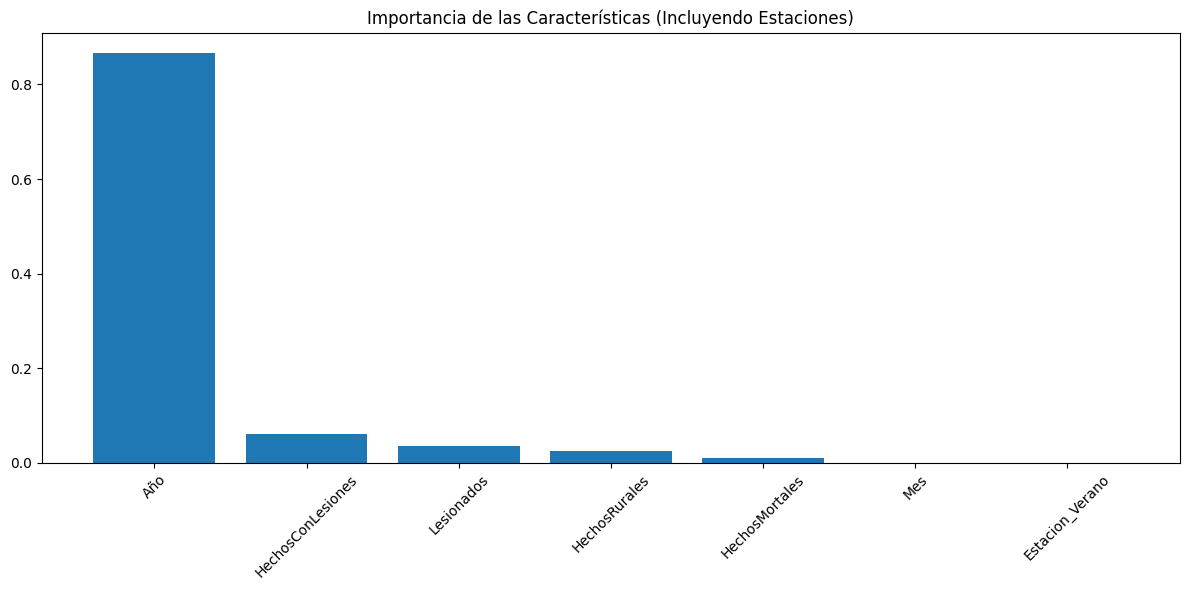

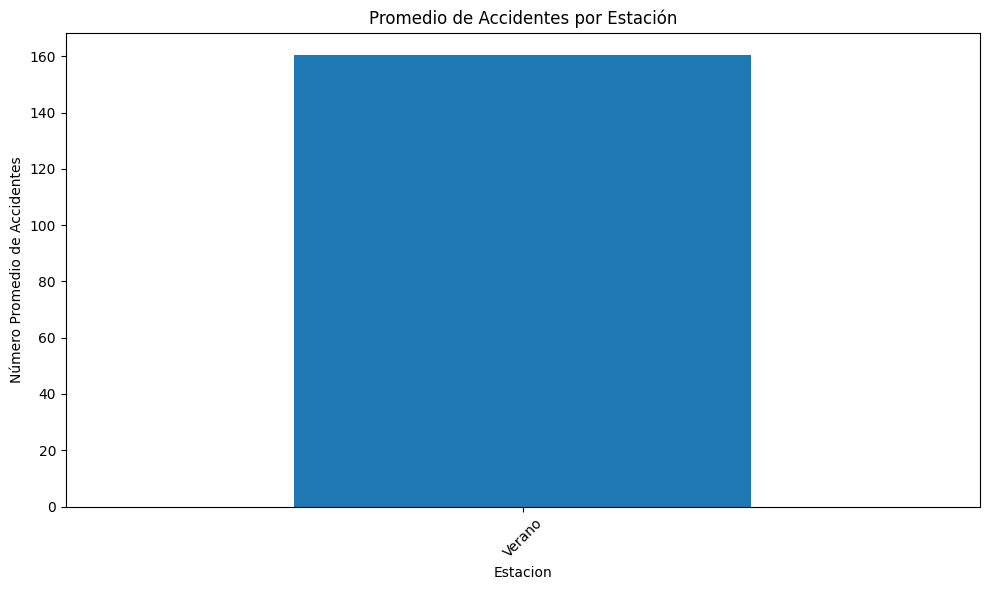

In [21]:
# Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 6. Creamos y entrenamos el modelo
rf_model_estaciones = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_estaciones.fit(X_train, y_train)

# 7. Hacemos predicciones
y_pred = rf_model_estaciones.predict(X_test)

# 8. Evaluamos el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMétricas de evaluación del modelo con estaciones:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

# 9. Visualizamos la importancia de características
importancia = pd.DataFrame({
    'caracteristica': features_con_estaciones,
    'importancia': rf_model_estaciones.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(importancia['caracteristica'], importancia['importancia'])
plt.title('Importancia de las Características (Incluyendo Estaciones)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10. Analizamos la distribución de accidentes por estación
plt.figure(figsize=(10, 6))
df.groupby('Estacion')[target].mean().plot(kind='bar')
plt.title('Promedio de Accidentes por Estación')
plt.ylabel('Número Promedio de Accidentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las métricas indican que:

- El RMSE mejoró ligeramente (de 45.31 a 44.57)

- El MAE también mejoró un poco (de 35.23 a 34.63)

- El R2 Score se mantiene en 0.87

El "Año" sigue siendo la variable más importante por mucho, las estaciones tienen una importancia muy baja (solo vemos Estacion_Verano en el gráfico con importancia casi nula), por o que podemos decir que las estaciones no aportan mucha información adicional al modelo. 

## Conclusiones del modelo.
Comenzamos con un modelo que mostraba sobreajuste:

- R2 Score inicial: 0.99

- Variables incluían HechosSimples que causaba target leakage

Mejoramos el modelo eliminando HechosSimples:

- R2 Score: 0.87

- RMSE: 45.31

- MAE: 35.23

Intentamos mejorar añadiendo estaciones:

- R2 Score: 0.87

- RMSE: 44.57

- MAE: 34.63

- Las estaciones no aportaron mejora significativa

## Modelo final.
Es más realista que el inicial evitando el sobreajuste. Tiene un rendimiento aceptable (R2 = 0.87) y se basa principalmente en la tendencia anual.

---

Vamos a guardar el modelo usando 'pickle', que es la forma estándar de guardar modelos en Python. También guardaremos las características utilizadas para asegurarnos de que cuando usemos el modelo en el futuro, usemos las mismas variables en el mismo orden.

In [22]:
import pickle

# 1. Creamos un diccionario con el modelo y la información necesaria
modelo_info = {
    'modelo': rf_model_estaciones,
    'features': features_con_estaciones,
    'metricas': {
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
}

# 2. Creamos la carpeta 'models' si no existe
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# 3. Guardamos el modelo
with open('../models/modelo_final_accidentes.pkl', 'wb') as f:
    pickle.dump(modelo_info, f)

# 4. Verificamos que se guardó correctamente
if os.path.exists('../models/modelo_final_accidentes.pkl'):
    print("El modelo se guardó exitosamente en '../models/modelo_final_accidentes.pkl'")
    print("\nInformación guardada:")
    print(f"- Features utilizadas: {len(features_con_estaciones)} variables")
    print(f"- Métricas finales: R2={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")
else:
    print("Hubo un problema al guardar el modelo")

# 5. Código de ejemplo para cargar el modelo (para referencia futura)
print("\nEjemplo de código para cargar el modelo en el futuro:")
print("""
# Cargar el modelo
with open('../models/modelo_final_accidentes.pkl', 'rb') as f:
    modelo_cargado = pickle.load(f)

# Acceder al modelo y features
modelo = modelo_cargado['modelo']
features = modelo_cargado['features']
""")

El modelo se guardó exitosamente en '../models/modelo_final_accidentes.pkl'

Información guardada:
- Features utilizadas: 7 variables
- Métricas finales: R2=0.871, RMSE=44.57, MAE=34.63

Ejemplo de código para cargar el modelo en el futuro:

# Cargar el modelo
with open('../models/modelo_final_accidentes.pkl', 'rb') as f:
    modelo_cargado = pickle.load(f)

# Acceder al modelo y features
modelo = modelo_cargado['modelo']
features = modelo_cargado['features']

